Import public packages and functions

In [129]:
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import compress


import openpyxl
from datetime import datetime
from scipy.spatial import distance
from scipy.ndimage import uniform_filter1d
import math
from scipy.signal import find_peaks, peak_prominences
import statistics as stat
import json
import traces

In [130]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)

    return path


In [131]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')
os.chdir(code_path)

Import own functions

In [132]:
import import_data.import_and_convert_data as import_dat
import import_data.find_paths as find_paths
import import_data.preprocessing_meta_info as meta_info
import sig_processing.segment_tasks as tasks
import movement_calc.calc_3d_distances as calc_3d
import movement_calc.helpfunctions as hp
# import sig_processing.extract_features as feat_ext

### Saving blocks for preprocessing

Reloading own functions

In [133]:
importlib.reload(import_dat)
importlib.reload(tasks)
importlib.reload(find_paths)
importlib.reload(meta_info)
importlib.reload(hp)
# importlib.reload(feat_ext)

<module 'movement_calc.helpfunctions' from '/Users/arianm/Documents/GitHub/ultraleap_analysis/code/movement_calc/helpfunctions.py'>

Define variables of interest

In [463]:
folder = 'patientdata'
ls_cond = ['m1', 'm0s0', 'm0s1', 'm1s0', 'm1s1']
ls_cam = ['dt', 'vr',  'st']
ls_task = ['ft', 'oc', 'ps', 'pt']
ls_side = ['left', 'right']
subs = find_paths.find_available_subs(folder)

Save blocks for feature extraction

In [135]:
for sub in subs:
    for cond in ls_cond:
        for cam in ls_cam:
            for task in ls_task:
                for side in ls_side:
                    # get defined data
                    try:
                        data = import_dat.get_data(folder = folder,
                            sub=sub, cam_pos=cam, task=task, condition=cond, side=side,
                        )

                        # get block dataframes
                        blocks = tasks.block_extraction(
                            data, sub=sub, task=task, side=side,
                            cond=cond, cam=cam, to_save=True)

                        block_path = os.path.join(
                            repo_path, 'data', 'raw_blocks', sub, task, cond, 'blocks')

                    except Exception:
                        continue

                #saving blocks as .csv files
                    for block in blocks.keys():
                        if blocks[block].empty:
                            continue
                        if not os.path.exists(block_path) and not blocks[block].empty:
                            os.makedirs(block_path)
                        blocks[block].to_csv(os.path.join(
                            block_path, f'{block}_{sub}_{cond}_{cam}_{task}_{side}.csv'))

Load blocks, calculate distances and create dist-time .csv files

In [486]:
for sub in subs:
    for cond in ls_cond:
        for task in ls_task:
            try:
                files = os.listdir(os.path.join(repo_path, 'data','raw_blocks', sub, task, cond, 'blocks'))

            except FileNotFoundError:
                continue 
            
            for file in files:
                if file == '.DS_Store':
                    continue

                # Load blocks from patients' blocks dir
                block = pd.read_csv(os.path.join(
                    repo_path, 'data', 'raw_blocks', sub, task, cond, 'blocks', file))

                if task == 'oc':
                    dist = hp.calc_distances(block, 'middle_tip', 'palm')
                elif task == 'ft':
                    dist = hp.calc_distances(block, 'index_tip', 'thumb_tip')
                elif task == 'ps':
                    dist = hp.calc_prosup_angle(block, 'thumb_tip', 'middle_tip', 'palm')
                elif task == 'pt':
                    print('Postural tremor not analyzed yet')

                dist['time'] = block.program_time.to_list()

                dist_path = os.path.join(
                    repo_path, 'data', 'raw_blocks', sub, task, cond, 'dist')
                if not os.path.exists(dist_path):
                    os.makedirs(dist_path)
                dist.to_csv(os.path.join(
                    dist_path, f'dist_{file}'))

# Visualisations for self-control

In [507]:
def new(dist_dataframe):
    '''
    Try out further and adapt for PS
    '''


    dist_array = np.array(dist_dataframe.iloc[:,0])
    peaks_idx_max, _ = find_peaks(
        dist_array, 
        height = np.mean(dist_array)-np.std(dist_array),
        prominence = 0.02,
    )


    peaks_idx_min = np.array([np.where(dist_dataframe.iloc[:,0] == np.array(dist_dataframe.iloc[peaks_idx_max[i]:peaks_idx_max[i+1]]).min())[0][0]
        for i in np.arange(0, len(peaks_idx_max[:-1]))
    ])
    plt.figure(figsize=(14, 8))

    plt.plot(dist_dataframe['time'], dist_dataframe.iloc[:,0])
    plt.plot(dist_dataframe.iloc[peaks_idx_max]['time'], dist_dataframe.iloc[peaks_idx_max].iloc[:,0], 'o', color= 'red')
    plt.plot(dist_dataframe.iloc[peaks_idx_min]['time'], dist_dataframe.iloc[peaks_idx_min].iloc[:,0], 'o', color= 'blue')
    plt.show()
    return

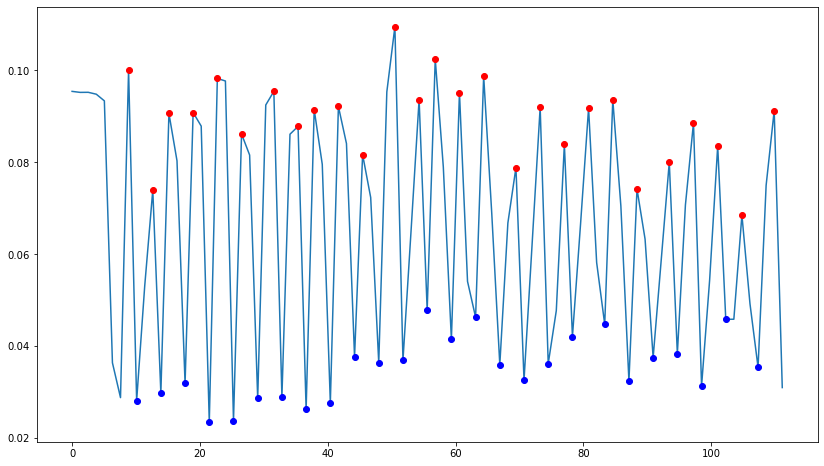

In [510]:
df= pd.read_csv('/Users/arianm/Documents/GitHub/ultraleap_analysis/data/raw_blocks/ul002/ft/m1/dist/dist_b1_ul002_m1_dt_ft_left.csv', index_col= 0)
new(df)